In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
n_list = [2000, 4000, 8000, 16000, 32000]
idx_list = list(range(1, 11))

res = np.zeros((len(n_list), len(idx_list) * 10, 3))
for (i, n) in enumerate(n_list):
    for (j, idx) in enumerate(idx_list):
        res[i, (j * 10):(j * 10 + 10), :] = np.loadtxt('results/{}_{}.txt'.format(n, idx))

        
y_original = np.mean(res, axis = 1)
y = np.log(y_original)

x_original = np.array(n_list)
X = np.zeros((len(x_original), 2))
X[:, 0] = 1
X[:, 1] = np.log(x_original)
S = np.linalg.inv(X.T @ X)
W = S @ X.T 
H = X @ W


Slopes:  [-0.47841128 -0.58692579 -0.56524405]
Standard errors:  [0.02956242 0.02866334 0.03435609]


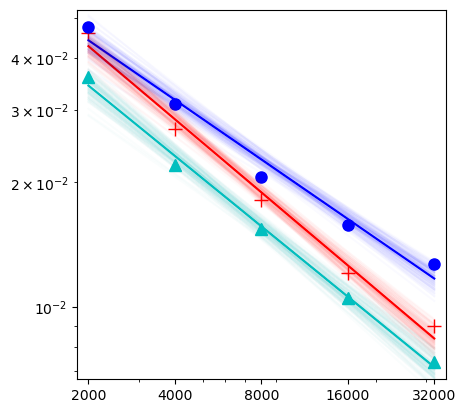

In [3]:
fig, ax = plt.subplots()

xlim = [np.min(x_original) / 1.1, np.max(x_original) * 1.1]
ylim = [np.min(y_original) / 1.1, np.max(y_original) * 1.1]

plt.ylim(ylim)
plt.xlim(xlim)


plt.plot(x_original, y_original[:, 1], 'r+', markersize = 10) # pseudo-labels
plt.plot(x_original, y_original[:, 2], 'c^', markersize = 8) # real labels
plt.plot(x_original, y_original[:, 0], 'bo', markersize = 8) # naive (source only)


y_pred = H @ y
plt.plot(x_original, np.exp(y_pred[:, 1]), 'r-')
plt.plot(x_original, np.exp(y_pred[:, 2]), 'c-')
plt.plot(x_original, np.exp(y_pred[:, 0]), 'b-')

coef = (W @ y)[1]
print('Slopes: ', coef)


# Uncertainty quantification using bootstrap
alpha = 0.05
q = norm.ppf(1 - alpha / 2)

seed = 10000
B = 10000 # number of bootstrap replicates

np.random.seed(seed)
results_B = np.zeros((B, 2, 3))
m = res.shape[1]

for b in range(B):
    y_b = np.zeros((len(X), 3))
    for j in range(len(res)):
        w = np.random.multinomial(m, np.ones(m) / m)
        w = w / sum(w)
        y_b[j] = (w @ res[j]).reshape(-1,)    
    y_b = np.log(y_b)


    if b < 100:
        plt.plot(x_original, np.exp(H @ y_b[:, 1]), 'r-', alpha = 0.02)
        plt.plot(x_original, np.exp(H @ y_b[:, 2]), 'c-', alpha = 0.02)  
        plt.plot(x_original, np.exp(H @ y_b[:, 0]), 'b-', alpha = 0.02)


    results_B[b] = W @ y_b


tmp = results_B[:, 1, :]
print( 'Standard errors: ', np.std(tmp, axis = 0) )


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect( (np.log(xlim[1]) - np.log(xlim[0])) / (np.log(ylim[1]) - np.log(ylim[0])) )    
plt.xticks(x_original, x_original)
plt.show()

fig.savefig('krr_errors.pdf', format = 'pdf', transparent=True)


